# Motion of a Charged Particle in a Dipole Field

In [3]:
import numpy as np
from scipy.constants import epsilon_0, pi

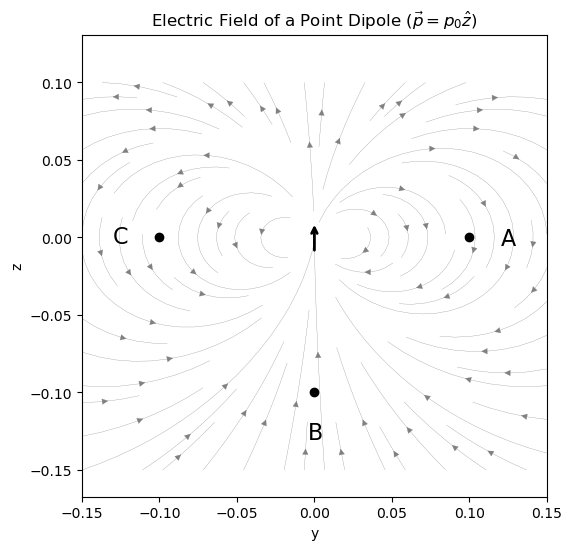

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

p_0 = 1e-9 # 1nC-m
k = 1/(4 * pi * epsilon_0)

def dipole_field(y, z):
    r = np.sqrt(y**2 + z**2)
    Ey = k * (3 * p_0 * z * y) / (r**5)
    Ez = k * (p_0 * (3*z**2 - r**2)) / (r**5)
    return Ey, Ez

# plotting grid
y = np.linspace(-0.15, 0.15, 60)
z = np.linspace(-0.15, 0.1, 60)
Y, Z = np.meshgrid(y, z)

R = np.sqrt(Y**2 + Z**2)
#R[R == 0] = np.nan   # avoid singularity for plotting

Ey = k * (3 * p_0 * Z * Y) / (R**5)
Ez = k * (p_0 * (3*Z**2 - R**2)) / (R**5)

plt.figure(figsize=(6, 6))
plt.streamplot(y, z, Ey, Ez, density=.8, linewidth=0.2, color="0.5", zorder=1)
plt.annotate("", xytext=(0, -0.01), xy=(0, 0.01),
            arrowprops=dict(arrowstyle="->", linewidth=2))
plt.plot(0.1, 0, "ko", ms=6, zorder=6)
plt.plot(0, -0.1, "ko", ms=6, zorder=6)
plt.plot(-0.1, 0, "ko", ms=6, zorder=6)
plt.text(0.1 + 0.02, -.005, "A", fontsize=16)
plt.text(-.0045, -0.1 - 0.03, "B", fontsize=16)
plt.text(-0.1 - 0.03, -.004, "C", fontsize=16)

plt.xlabel("y")
plt.ylabel("z")
plt.title("Electric Field of a Point Dipole ($\\vec p = p_0 \\hat z$)")
plt.axis("equal")
#plt.savefig("electric_field.pdf")


#### I iterated through a time-array, using Newton's 2nd law to obtain acceleration for each position. Positions and velocities are then updated and the algorithm is repeated again and again. All motion by default it in the y-z plane.

Dipole moment p_0 = $1 e^{-9}$ $(1nC-m)$ \
mass m = $1 e^{-6}$ $(1mg)$ \
charge q = $1 e^{-9}$ $(1nC)$ \
Coulomb's constant k = $\frac{1}{4 \pi \epsilon_{0}}$ 

In [ ]:
# Uses Newton's laws to iterate through time, updating velocities and positions
# position = [(x, y, z)], velocity = [(u_x, u_y, u_z)]

p_0 = 1e-9 # 1nC-m
m = 1e-6 # 1mg
q = 1e-9 # 1nC
k = 1/(4 * pi * epsilon_0)

dt = 1e-4 # time resolution
total_time = 1 # in seconds

time_series = np.arange(0, total_time, dt)
positions = [(0, 0.1, 0)] # initially at x = 0, y = 0.1m, z = 0
velocities = [(0, 0, 0)] # initial velocities u_x = 0, u_y = 0.1 m/s, u_z = 0

for t in time_series:
    x, y, z = positions[-1][0], positions[-1][1], positions[-1][2]
    u_x, u_y, u_z = velocities[-1][0], velocities[-1][1], velocities[-1][2]
    r = np.sqrt(x**2 + y**2 + z**2)
    acc_x = 3 * p_0 * k * q * x * z / (m * r**5)
    acc_y = 3 * p_0 * k * q * y * z / (m * r**5)
    acc_z = (3 * z**2 - r**2) * p_0 * k * q / (m * r**5)
    u_x += acc_x * dt
    u_y += acc_y * dt
    u_z += acc_z * dt
    x += u_x * dt
    y += u_y * dt
    z += u_z * dt
    positions.append((x, y, z))
    velocities.append((u_x, u_y, u_z))

# removing the final index
positions.pop(-1)
velocities.pop(-1)
y, z = [p[1] for p in positions], [p[2] for p in positions]

#### Iterating is a very inefficient method, and it scales horribly with more time-resolution and total time. ODEINT can solve a pair of 1st order/2nd order differential equations (Newton's 2nd law), in a more efficient way.

#### This is worse than the iterator method for certain trajectories. It results in singularities, when infact the charge should finally move away.

Credits: https://scipy.github.io/old-wiki/pages/Cookbook/CoupledSpringMassSystem

In [130]:
# Uses ODEINT to solve the differential equations defined by the vector field

from scipy.integrate import odeint

def vectorfield(w, t, p):
    """
    Defines the differential equations for the coupled system.
    Arguments:
        w :  vector of the state variables:
                  w = [u_x, x, u_y, y, u_z, z]
        p :  vector of the parameters:
                  p = [m, q, k, p_0]
        t :  time
    """
    u_x, x, u_y, y, u_z, z = w
    m, q, k, p_0 = p
    # Create f = (u_x', x', u_y', y', u_z', z'):
    r = np.sqrt(x**2 + y**2 + z**2)
    f = [3*k*z*x*q*p_0/(m * r**5), u_x, 3*k*z*y*q*p_0/(m * r**5), u_y, 
         k*q*p_0*(3*z**2 - r**2)/(m * r**5), u_z]
    return f

p_0 = 1e-8 # 1nC-m
m = 1e-6 # 1mg
q = 1e-9 # 1nC
k = 1/(4 * pi * epsilon_0)

time_series = np.arange(0, 10, 0.0001)

# Initial conditions
# x, y, z are the initial displacements; a, b, c are the initial velocities
x = 0
y = 0.1
z = 0
u_x = 0
u_y = -0.2
u_z = 0

# Pack up the parameters and initial conditions:
w0 = [u_x, x, u_y, y, u_z, z]
p = [m, q, k, p_0]

# Call the ODE solver.
wsol = odeint(vectorfield, w0, time_series, args=(p,))

y, z = [p[3] for p in wsol], [p[5] for p in wsol]

/var/folders/69/q5yldv6s0jz_y5kr15y_xw7w0000gn/T/ipykernel_14123/2862359811.py:44: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  wsol = odeint(vectorfield, w0, time_series, args=(p,))


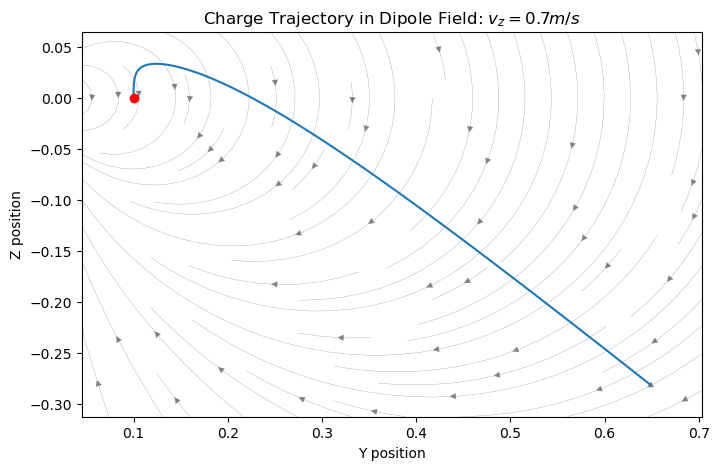

In [ ]:
import matplotlib.pyplot as plt

y_min, y_max = min(y), max(y)
z_min, z_max = min(z), max(z)
dy = y_max - y_min
dz = z_max - z_min
y_min -= 0.1*dy
y_max += 0.1*dy
z_min -= 0.1*dz
z_max += 0.1*dz

Y, Z = np.meshgrid(np.linspace(y_min, y_max, 60),
                   np.linspace(z_min, z_max, 60))

R = np.sqrt(Y**2 + Z**2)
Ey = k * (3*p_0*Z*Y)/(R**5)
Ez = k * (p_0*(3*Z**2 - R**2))/(R**5)

fig, ax = plt.subplots(figsize=(8, 5))

ax.streamplot(np.linspace(y_min, y_max, 60),
              np.linspace(z_min, z_max, 60),
              Ey, Ez, density=.8, linewidth=0.2, color="0.5", zorder=1)

plt.annotate("", xytext=(0, -0.01), xy=(0, 0.01),
            arrowprops=dict(arrowstyle="->", linewidth=2))
ax.plot(y, z, lw=1.5, zorder=5)
ax.plot(0.1, 0, "ro", ms=6, zorder=6)

ax.set_xlim(y_min, y_max)
ax.set_ylim(z_min, z_max)
plt.xlabel("Y position")
plt.ylabel("Z position")
plt.title("Charge Trajectory in Dipole Field: No velocity")

#plt.savefig("0_0.1_0_0_0_0.pdf")
